## Neural Network:
Neural Networks (NNs) are computing systems vaguely inspired by the biological neural networks that constitute animal brains. NN is based on a collection of connected units or nodes called **artificial neurons**, which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal to other neurons. An artificial neuron that receives a signal then processes it and can signal neurons connected to it. The "signal" at a connection is a real number, and the output of each neuron is computed by some non-linear function of the sum of its inputs. The connections are called **edges**. Neurons and edges typically have a **weight** that adjusts as learning proceeds. Neurons are aggregated into layers. Different layers may perform different transformations on their inputs. Signals travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple times.

In the current experiment, the input will comprise of 28*28 images and output will have 2 nodes, for male and female.
 


## Ekush Dataset: 
This is a Multipurpose and Multitype Comprehensive **Database** for Online and Off-Line **Bangla Handwritten Characters**.
It consists of 673,482‬ instances of Bangla handwritten characters, which can help in the following cases:


*   Characters Recognition
*   Recognition in context
*   **Gender Identification**
*   Forensic Investigation

For the given experiment we are to perform the following: Apply **Neural Network / Deep Neural Network** for the **Ekush** dataset and build a binary classification model that can predict  **male/female** from Bengali handwritten digits with different hyperparameter settings.  


For this task, we will use the Ekush dataset for Gender Identification purposes. Hence we will use the Female Digits and Male Digits portion of the Ekush Dataset.

<div align="center">
<img src="https://drive.google.com/uc?id=1GhuJfYchOjfNoBtwkpWivPRQinegMYwy" width="600">
</div>

In the given experiment, we are using the following fixed hyper-parameters:

- **Input dimension: 784**
  - Size of image: $28 \times 28 = 784$

- **Output dimension: 2**
  - 0(male), 1(female)

The images in Ekush Dataset are stored as 1D arrays in CSV files where the first 784 columns denote the intensity levels of the pixels in an image and the last column denotes the Label which indicates the digit written in the image. Here we drop the existing column for Labels and add an extra column in its place, which contains the value of either 0(for male) or 1(for female).

**In the following cell, we imported all the required libraries needed to perform logistic regression, plot the data etc. and mounted Google Drive in order to import required files and save the model in the end.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset
import matplotlib
import matplotlib.pyplot as plt
import io
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from datetime import datetime
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# Hyperparameters
input_dim = 28*28 # num_features = 784
output_dim = 2

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

Tesla T4


In [ ]:
#FUNCTION FOR PRINTING CURRENT TIME
def curr_time():
  now = datetime.now()
  current_time = now.strftime("%H:%M:%S") 
  print("Current Time =", current_time)


**In the following cell, class Dataset is declared, which normalizes the data in a [0,1] range and returns image and label.**

In [ ]:
#CLASS FOR DEFINING DATASETS OF EKUSH DB
class Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        image = self.images[index]
        image = (image / 255.0).astype(np.float32)
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
#FUNCTION FOR PLOTTING LOSS 
def plot(iteration_loss):
  print (iteration_loss)
  plt.plot(iteration_loss)
  plt.ylabel('Cross Entropy Loss')
  plt.xlabel('Iteration (in every 500)')
  plt.show()

# SETTING 1:
## Hyperparameters:
**Iteration: 10k**

**Batch Size: 150**

**Learning Rate: 0.1**

**Number of Hidden Layers: 4 (ReLU->ReLU->ReLU->ReLU)**

**Dimension of Hidden Layers: 200**

**Optimizer: SGD**

Total training data= 27747
Total testing data= 3083
Current Time = 14:33:16
Batch size: 150 ; Number of iterations: 10000 ; Learning rate: 0.1 ; Total training data size: 27747 ; Epoch size: 54 ; Hidden Layers: 200
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.658848762512207. Accuracy: 58.83879338306844
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 1000. Loss: 0.665343701839447. Accuracy: 61.368796626662345
Epoch: 7
Epoch: 8
Epoch: 9
Iteration: 1500. Loss: 0.5801551342010498. Accuracy: 61.88777165098929
Epoch: 10
Epoch: 11
Iteration: 2000. Loss: 0.6506519317626953. Accuracy: 58.35225429776192
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 2500. Loss: 0.5726875066757202. Accuracy: 61.20661693156017
Epoch: 15
Epoch: 16
Epoch: 17
Iteration: 3000. Loss: 0.6895937323570251. Accuracy: 57.184560493026275
Epoch: 18
Epoch: 19
Iteration: 3500. Loss: 0.6641219854354858. Accu

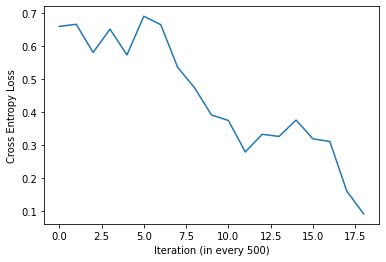

In [ ]:
#INITIALIZING DATASETS

female_path = "/content/gdrive/My Drive/Colab Notebooks/Ekush dataset/femaleDigits.csv"
male_path = "/content/gdrive/My Drive/Colab Notebooks/Ekush dataset/maleDigits.csv"
femaleData = pd.read_csv(female_path)
maleData = pd.read_csv(male_path)
femaleImage = femaleData.to_numpy()[:, : input_dim]
maleImage = maleData.to_numpy()[:, : input_dim]
images = np.concatenate((femaleImage, maleImage), axis=0)

#Labeling females=1 and males=0
labels = np.zeros(images.shape[0], dtype=np.long)
labels[: femaleImage.shape[0]] = 1


# Hyperparameters
batch_size = 150
num_iters = 10000
# input_dim = 28*28 # num_features = 784
num_hidden = 200
# output_dim = 10

learning_rate = 0.1

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)


# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration_loss = []

#SPLITTING DATA INTO 90:10 RATIO
training_dataset, testing_dataset, y_train, y_test = train_test_split(images,
                                                                      labels, 
                                                                      test_size=0.1,
                                                                      random_state=50)

train_dataset = Dataset(training_dataset, y_train)

test_dataset = Dataset(testing_dataset, y_test)

num_train=len(train_dataset)
num_test=len(test_dataset)
print('Total training data=',num_train)
print('Total testing data=',num_test)

'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)


curr_time()
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs,'; Hidden Layers:',num_hidden)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')
curr_time()
plot(iteration_loss)

# SETTING 2:
## Hyperparameters: 
**Iteration: 5k**

**Batch Size: 100**

**Learning Rate: 0.1**

**Number of Hidden Layers: 2 (ReLU->ReLU)**

**Dimension of Hidden Layers: 100**

**Optimizer: SGD**

Total training data= 27747
Total testing data= 3083
Current Time = 14:04:42
Batch size: 100 ; Number of iterations: 5000 ; Learning rate: 0.1 ; Total training data size: 27747 ; Epoch size: 18
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Iteration: 500. Loss: 0.6652223467826843. Accuracy: 59.909179370742784
Epoch: 3
Epoch: 4
Iteration: 1000. Loss: 0.5808959007263184. Accuracy: 60.52546221213104
Epoch: 5
Epoch: 6
Iteration: 1500. Loss: 0.7262930274009705. Accuracy: 61.401232565682776
Epoch: 7
Epoch: 8
Iteration: 2000. Loss: 0.7003109455108643. Accuracy: 60.52546221213104
Epoch: 9
Iteration: 2500. Loss: 0.6474366188049316. Accuracy: 61.92020759000973
Epoch: 10
Epoch: 11
Iteration: 3000. Loss: 0.6022487878799438. Accuracy: 61.044437236457995
Epoch: 12
Epoch: 13
Iteration: 3500. Loss: 0.5586901307106018. Accuracy: 62.179695102173206
Epoch: 14
Epoch: 15
Iteration: 4000. Loss: 0.534209728

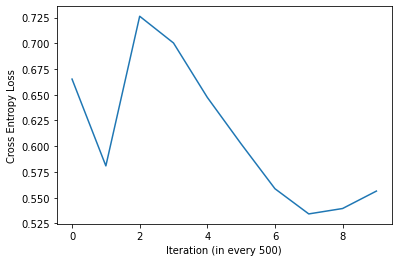

In [ ]:
#INITIALIZING DATASETS

female_path = "/content/gdrive/My Drive/Colab Notebooks/Ekush dataset/femaleDigits.csv"
male_path = "/content/gdrive/My Drive/Colab Notebooks/Ekush dataset/maleDigits.csv"
femaleData = pd.read_csv(female_path)
maleData = pd.read_csv(male_path)
femaleImage = femaleData.to_numpy()[:, : input_dim]
maleImage = maleData.to_numpy()[:, : input_dim]
images = np.concatenate((femaleImage, maleImage), axis=0)

#Labeling females=1 and males=0
labels = np.zeros(images.shape[0], dtype=np.long)
labels[: femaleImage.shape[0]] = 1


# Hyperparameters
batch_size = 100
num_iters = 5000
# input_dim = 28*28 # num_features = 784
num_hidden = 100
# output_dim = 10

learning_rate = 0.1

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration_loss = []

#SPLITTING DATA INTO 90:10 RATIO
training_dataset, testing_dataset, y_train, y_test = train_test_split(images,
                                                                      labels, 
                                                                      test_size=0.1,
                                                                      random_state=50)

train_dataset = Dataset(training_dataset, y_train)

test_dataset = Dataset(testing_dataset, y_test)

num_train=len(train_dataset)
num_test=len(test_dataset)
print('Total training data=',num_train)
print('Total testing data=',num_test)

'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)


curr_time()
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')
curr_time()
plot(iteration_loss)

# SETTING 3:
## Hyperparameters:
**Iteration: 5k**

**Batch Size: 100**

**Learning Rate: 0.1**

**Number of Hidden Layers: 3 (ReLU->ReLU->ReLU)**

**Dimension of Hidden Layers: 100**

**Optimizer: SGD**

Total training data= 27747
Total testing data= 3083
Current Time = 14:06:03
Batch size: 100 ; Number of iterations: 5000 ; Learning rate: 0.1 ; Total training data size: 27747 ; Epoch size: 18
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Iteration: 500. Loss: 0.6627777814865112. Accuracy: 57.44404800518975
Epoch: 3
Epoch: 4
Iteration: 1000. Loss: 0.6628674864768982. Accuracy: 60.88225754135582
Epoch: 5
Epoch: 6
Iteration: 1500. Loss: 0.6380534172058105. Accuracy: 61.30392474862147
Epoch: 7
Epoch: 8
Iteration: 2000. Loss: 0.6394315958023071. Accuracy: 62.30943885825495
Epoch: 9
Iteration: 2500. Loss: 0.5950421094894409. Accuracy: 62.082387285111906
Epoch: 10
Epoch: 11
Iteration: 3000. Loss: 0.5499784350395203. Accuracy: 62.63379824845929
Epoch: 12
Epoch: 13
Iteration: 3500. Loss: 0.5770328640937805. Accuracy: 62.536490431397986
Epoch: 14
Epoch: 15
Iteration: 4000. Loss: 0.60497355461

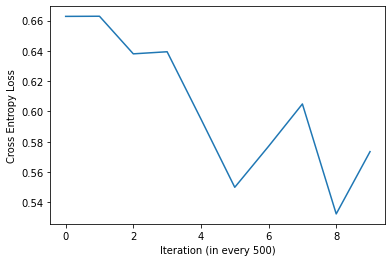

In [ ]:
#INITIALIZING DATASETS

female_path = "/content/gdrive/My Drive/Colab Notebooks/Ekush dataset/femaleDigits.csv"
male_path = "/content/gdrive/My Drive/Colab Notebooks/Ekush dataset/maleDigits.csv"
femaleData = pd.read_csv(female_path)
maleData = pd.read_csv(male_path)
femaleImage = femaleData.to_numpy()[:, : input_dim]
maleImage = maleData.to_numpy()[:, : input_dim]
images = np.concatenate((femaleImage, maleImage), axis=0)

#Labeling females=1 and males=0
labels = np.zeros(images.shape[0], dtype=np.long)
labels[: femaleImage.shape[0]] = 1


# Hyperparameters
batch_size = 100
num_iters = 5000
# input_dim = 28*28 # num_features = 784
num_hidden = 100
# output_dim = 10

learning_rate = 0.1

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration_loss = []

#SPLITTING DATA INTO 90:10 RATIO
training_dataset, testing_dataset, y_train, y_test = train_test_split(images,
                                                                      labels, 
                                                                      test_size=0.1,
                                                                      random_state=50)

train_dataset = Dataset(training_dataset, y_train)

test_dataset = Dataset(testing_dataset, y_test)

num_train=len(train_dataset)
num_test=len(test_dataset)
print('Total training data=',num_train)
print('Total testing data=',num_test)

'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)


curr_time()
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')
curr_time()
plot(iteration_loss)

# SETTING 4:
## Hyperparameters:
**Iteration: 3k**

**Batch Size: 120**

**Learning Rate: 0.005**

**Number of Hidden Layers: 3 (SELU->ReLU->SELU)**

**Dimension of Hidden Layers: 100**

**Optimizer: Adagrad**

Total training data= 27747
Total testing data= 3083
Current Time = 07:27:02
Batch size: 120 ; Number of iterations: 3000 ; Learning rate: 0.005 ; Total training data size: 27747 ; Epoch size: 12
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 0.7090305685997009. Accuracy: 62.47161855335712
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 0.6235560178756714. Accuracy: 62.79597794356147
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 0.5871842503547668. Accuracy: 62.7311060655206
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 0.602329432964325. Accuracy: 63.18520921180668
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 0.5142533779144287. Accuracy: 63.05546545572494
Epoch: 12
-----------------------Simulation ends----------------------
Current Time = 07:27:11
[0.7090305685997009, 0.6235560178756714, 0.5871842503547668, 0.602329432964325, 0.5142533779144287]


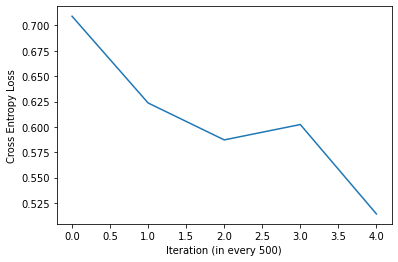

In [ ]:
#INITIALIZING DATASETS

female_path = "/content/gdrive/My Drive/Colab Notebooks/Ekush dataset/femaleDigits.csv"
male_path = "/content/gdrive/My Drive/Colab Notebooks/Ekush dataset/maleDigits.csv"
femaleData = pd.read_csv(female_path)
maleData = pd.read_csv(male_path)
femaleImage = femaleData.to_numpy()[:, : input_dim]
maleImage = maleData.to_numpy()[:, : input_dim]
images = np.concatenate((femaleImage, maleImage), axis=0)

#Labeling females=1 and males=0
labels = np.zeros(images.shape[0], dtype=np.long)
labels[: femaleImage.shape[0]] = 1


# Hyperparameters
batch_size = 120
num_iters = 3000
# input_dim = 28*28 # num_features = 784
num_hidden = 100
# output_dim = 10

learning_rate = 0.005

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.selu_1 = nn.SELU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.selu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.selu_3 = nn.SELU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.selu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.selu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.selu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
iteration_loss = []

#SPLITTING DATA INTO 90:10 RATIO
training_dataset, testing_dataset, y_train, y_test = train_test_split(images,
                                                                      labels, 
                                                                      test_size=0.1,
                                                                      random_state=50)

train_dataset = Dataset(training_dataset, y_train)

test_dataset = Dataset(testing_dataset, y_test)

num_train=len(train_dataset)
num_test=len(test_dataset)
print('Total training data=',num_train)
print('Total testing data=',num_test)

'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)


curr_time()
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')
curr_time()
plot(iteration_loss)

## In this experiment we tuned the hyperparameters in such a way that the progression of accuracy can be seen in the 4 settings as follows:


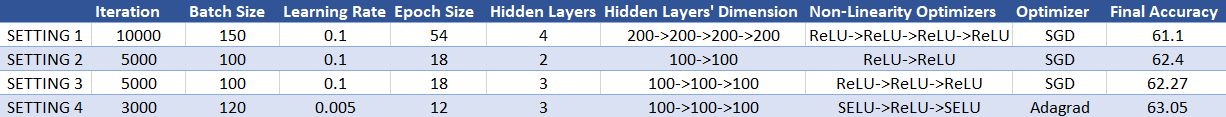

**Here we have experimented with all the hyperparameters. Due to this we can see the progression of the accuracy in an objective manner. We tried 15 different settings before finally settling on the 4 we have highlighted.**

The **loss functions** can also be seen as follows:

## **Setting 1:**

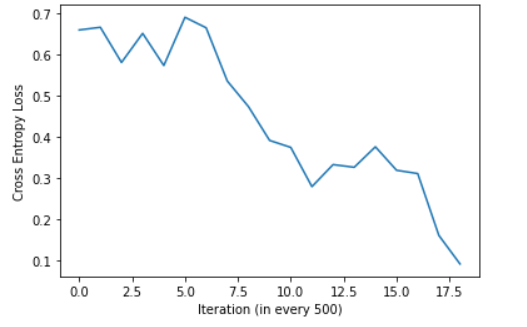

## **Setting 2:**
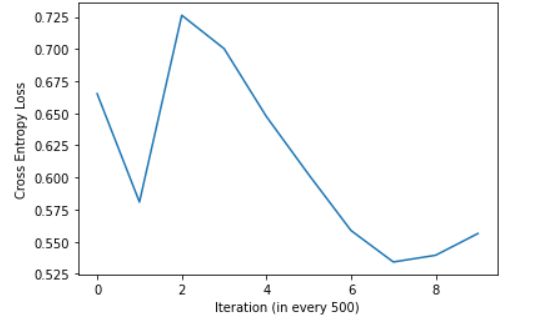

## **Setting 3:**
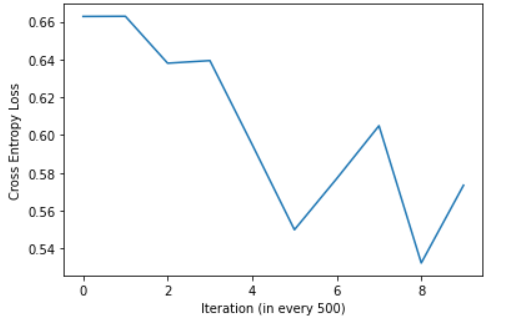

## **Setting 4:**
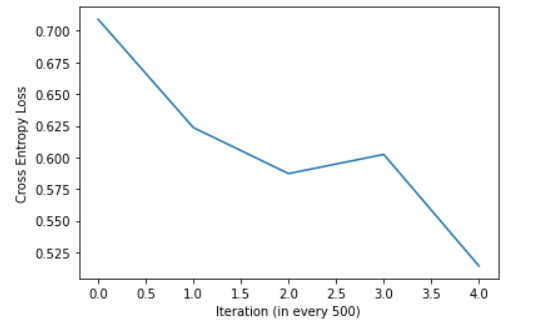

Here we can see that when the iterations were fewer, the loss function's curves were relatively smoother compared to when the iterations were increased.